In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import platform

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Monthly

In [4]:
if platform.system() == 'Windows':
  pm10_monthly = pd.read_csv("..\\Data for model\\no2_meteorolgical_monthly.csv")
elif platform.system() == 'Linux':
  from google.colab import drive
  drive.mount('/content/gdrive')
  pm10_monthly = pd.read_csv("/content/gdrive/Othercomputers/My Laptop (1)/jkt-aqi-forecasting/Model/Data for Model/no2_meteorolgical_monthly.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## NO2

In [5]:
no2_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tanggal                         120 non-null    object 
 1   no2(ug/m3)                      120 non-null    float64
 2   no2_ispu                        120 non-null    int64  
 3   temperatur_rata-rata(°C)        120 non-null    float64
 4   kelembapan_rata-rata(%)         120 non-null    float64
 5   curah_hujan(mm)                 120 non-null    float64
 6   kecepatan_angin_rata-rata(m/s)  120 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 6.7+ KB


In [6]:
no2_monthly['tanggal'] = pd.to_datetime(no2_monthly['tanggal'], dayfirst=True)
no2_monthly.set_index('tanggal', inplace=True)

In [7]:
no2_monthly.describe()

,no2(ug/m3),no2_ispu,temperatur_rata-rata(°C),kelembapan_rata-rata(%),curah_hujan(mm),kecepatan_angin_rata-rata(m/s)
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,20.342500,13.441667,28.484167,75.831667,5.907500,1.881667
std,10.281407,6.340209,0.658365,4.315148,5.617263,0.680457
min,2.700000,3.000000,26.600000,66.300000,0.000000,0.900000
25%,7.500000,5.750000,28.175000,72.750000,1.800000,1.300000
50%,24.050000,16.000000,28.600000,76.300000,5.050000,1.600000
75%,28.925000,19.000000,28.900000,78.600000,8.525000,2.600000
max,37.500000,24.000000,29.900000,84.800000,33.000000,3.300000


In [8]:
no2_monthly.corr(method='spearman')

,no2(ug/m3),no2_ispu,temperatur_rata-rata(°C),kelembapan_rata-rata(%),curah_hujan(mm),kecepatan_angin_rata-rata(m/s)
no2(ug/m3),1.000000,0.995838,0.260025,-0.250964,-0.261007,0.344120
no2_ispu,0.995838,1.000000,0.255304,-0.240835,-0.250228,0.345154
temperatur_rata-rata(°C),0.260025,0.255304,1.000000,-0.674751,-0.598617,-0.110798
kelembapan_rata-rata(%),-0.250964,-0.240835,-0.674751,1.000000,0.845926,0.006361
curah_hujan(mm),-0.261007,-0.250228,-0.598617,0.845926,1.000000,0.087252
kecepatan_angin_rata-rata(m/s),0.344120,0.345154,-0.110798,0.006361,0.087252,1.000000


### Visualize

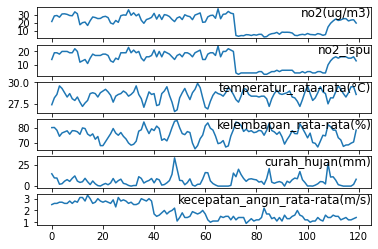

In [9]:
groups = [0, 1, 2, 3, 4, 5]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(no2_monthly.values[:, group])
    plt.title(no2_monthly.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

### Sliding Window

In [10]:
# convert series to supervised learning
def series_to_supervised(index, data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = index
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
values = no2_monthly.values
# frame as supervised learning
reframed = series_to_supervised(no2_monthly.index, values, 1, 1)
# drop columns we don't want to predict
reframed = reframed.iloc[:, :-5]
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
tanggal,,,,,,,
2010-02-28,21.8,14.0,27.4,80.2,14.4,2.5,28.7
2010-03-31,28.7,19.0,28.2,80.3,9.6,2.6,29.2
2010-04-30,29.2,19.0,28.6,78.5,9.4,2.6,27.1
2010-05-31,27.1,18.0,29.6,74.5,2.2,2.7,31.1
2010-06-30,31.1,20.0,29.3,76.7,2.8,2.7,31.3
...,...,...,...,...,...,...,...
2019-08-31,25.3,16.0,28.7,67.9,0.0,1.3,25.3
2019-09-30,25.3,16.0,28.3,68.8,0.0,1.4,22.5
2019-10-31,22.5,15.0,28.8,68.9,0.0,1.2,23.6


In [11]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
reframed = pd.DataFrame(scaler.fit_transform(reframed), index=reframed.index, columns=reframed.columns)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
tanggal,,,,,,,
2010-02-28,0.548851,0.523810,0.242424,0.751351,0.436364,0.666667,0.747126
2010-03-31,0.747126,0.761905,0.484848,0.756757,0.290909,0.708333,0.761494
2010-04-30,0.761494,0.761905,0.606061,0.659459,0.284848,0.708333,0.701149
2010-05-31,0.701149,0.714286,0.909091,0.443243,0.066667,0.750000,0.816092
2010-06-30,0.816092,0.809524,0.818182,0.562162,0.084848,0.750000,0.821839
...,...,...,...,...,...,...,...
2019-08-31,0.649425,0.619048,0.636364,0.086486,0.000000,0.166667,0.649425
2019-09-30,0.649425,0.619048,0.515152,0.135135,0.000000,0.208333,0.568966
2019-10-31,0.568966,0.571429,0.666667,0.140541,0.000000,0.125000,0.600575


In [12]:
from datetime import datetime

train_end = datetime.strptime('2011-12-31', '%Y-%m-%d')
test_start = datetime.strptime('2012-01-01', '%Y-%m-%d')
test_end = datetime.strptime('2019-12-31', '%Y-%m-%d')

train = reframed.loc[:train_end].values
test = reframed.loc[test_start:test_end].values
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23, 6) (23, 1) (96, 6) (96, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23, 1, 6) (23, 1) (96, 1, 6) (96, 1)


In [14]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed
import keras_tuner as kt

set_seed(
    1337
)

'''# design network
model = Sequential()
model.add(InputLayer((train_X.shape[1], train_X.shape[2])))
model.add(LSTM(6))
model.add(Dense(1))
model.compile(loss=Huber(), optimizer=Adam(learning_rate=0.001), metrics=RootMeanSquaredError())
# fit network
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=24)
history = model.fit(train_X, train_y, epochs=175, batch_size=24, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()'''
def call_existing_code(num_layers, units, activation, dropout, dropout_rate, lr):
    model = Sequential()
    model.add(InputLayer((train_X.shape[1], train_X.shape[2])))
    for i in range(num_layers):
      model.add(LSTM(units=units[i], return_sequences=True))
    model.add(LSTM(units=units[-1]))
    if dropout:
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=Huber(),
        metrics=RootMeanSquaredError(),
    )
    return model


def build_model(hp):
    num_layers = hp.Int("num_layers", min_value=1, max_value=3)
    units_i = []
    for i in range(num_layers):
      units_i.append(hp.Int(f"units_{i}", min_value=8, max_value=512, step=8))
    units_i.append(hp.Int("units", min_value=4, max_value=128, step=4))
    activation = hp.Choice("activation", ["relu", "tanh", "linear"])
    dropout = hp.Boolean("dropout")
    dropout_rate = hp.Float("dropout_1", min_value=0.1, max_value=0.2, step=0.1)
    lr = hp.Float("lr", min_value=1e-3, max_value=1e-2, default=1e-2)
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        num_layers=num_layers, units=units_i, activation=activation, dropout=dropout, dropout_rate=dropout_rate, lr=lr
    )
    return model


build_model(kt.HyperParameters())

In [16]:
class MyTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=1, max_value=60, step=1)
        kwargs['epochs'] = trial.hyperparameters.Int('epochs', min_value=100, max_value=1000, step=100)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

if platform.system() == 'Windows':
  tuner = MyTuner(
    hypermodel=build_model,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=100,
    executions_per_trial=1,
    overwrite=False,
    directory="D:\\From External Drive\\Kuliah\\Tugas Akhir\\undergraduate-thesis_2.0\\data-and-model\\Model_2",
    project_name="lstm_no2_monthly_80-20_result"
  )
elif platform.system() == 'Linux':
  tuner = MyTuner(
    hypermodel=build_model,
    objective=kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=100,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/gdrive/Othercomputers/My Laptop (1)/undergraduate-thesis_2.0/data-and-model/Model_2",
    project_name="lstm_no2_monthly_80-20_result"
  )

tuner.search(x=train_X, y=train_y, validation_data=(test_X, test_y), shuffle=False)

In [17]:
tuner.results_summary()

Results summary
Results in /content/gdrive/Othercomputers/My Laptop (1)/undergraduate-thesis_2.0/data-and-model/Model_2/lstm_no2_monthly_80-20_result
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 512
units: 60
activation: linear
dropout: True
dropout_1: 0.1
lr: 0.010000000000000002
batch_size: 1
epochs: 1000
units_1: 8
Score: 0.07564239203929901
Trial summary
Hyperparameters:
num_layers: 2
units_0: 8
units: 4
activation: linear
dropout: False
dropout_1: 0.1
lr: 0.010000000000000002
batch_size: 1
epochs: 1000
units_1: 8
units_2: 8
Score: 0.07794005423784256
Trial summary
Hyperparameters:
num_layers: 2
units_0: 304
units: 4
activation: linear
dropout: True
dropout_1: 0.2
lr: 0.010000000000000002
batch_size: 1
epochs: 1000
units_1: 8
units_2: 8
Score: 0.07874124497175217
Trial summary
Hyperparameters:
num_layers: 3
units_0: 512
units: 4
activation: linear
dropout: False
dropout_1: 0.2
lr: 0.001
batch_size: 60
epochs: 1000
units_1: 512
units_2: 8
Score: 0.079

In [18]:
# Get the top 2 models.
best_model = tuner.get_best_models(num_models=1)[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=((train_X.shape[1], train_X.shape[2])))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 512)            1062912   
                                                                 
 lstm_1 (LSTM)               (None, 1, 8)              16672     
                                                                 
 lstm_2 (LSTM)               (None, 60)                16560     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 1,096,205
Trainable params: 1,096,205
Non-trainable params: 0
_________________________________________________________________


In [19]:
best_model.evaluate(test_X, test_y)

3/3 [==============================] - 1s 10ms/step - loss: 0.0097 - root_mean_squared_error: 0.1391


[0.009669876657426357, 0.13906744122505188]

In [20]:
best_hp = tuner.get_best_hyperparameters(10)[1]
model = build_model(best_hp)
model.fit(x=train_X, y=train_y, validation_data=(test_X, test_y), epochs=20, batch_size=1, shuffle=False)

Epoch 1/20
23/23 [==============================] - 10s 153ms/step - loss: 0.1105 - root_mean_squared_error: 0.4701 - val_loss: 0.0933 - val_root_mean_squared_error: 0.4320
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0084 - root_mean_squared_error: 0.1294 - val_loss: 0.0478 - val_root_mean_squared_error: 0.3091
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0142 - root_mean_squared_error: 0.1685 - val_loss: 0.0505 - val_root_mean_squared_error: 0.3178
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0120 - root_mean_squared_error: 0.1551 - val_loss: 0.0534 - val_root_mean_squared_error: 0.3269
Epoch 5/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0109 - root_mean_squared_error: 0.1474 - val_loss: 0.0516 - val_root_mean_squared_error: 0.3213
Epoch 6/20
23/23 [==============================] - 0s 22ms/step - loss: 0.0111 - root_mean_squared_error: 0.1492 - val_loss: 0.0516 - val_root

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
  
# make a prediction
yhat = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, train_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
train_y = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((train_y, train_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
print(f'Train R-Squared: {r2_score(inv_y, inv_yhat) * 100:.3f}%')
print(f'Train RMSE: {rmse:.3f}')
print(f'Train MAPE: {mape(inv_y, inv_yhat):.3f}%')

1/1 [==============================] - 3s 3s/step
Train R-Squared: 23.330%
Train RMSE: 3.913
Train MAPE: 12.650%


In [22]:
train_result = pd.DataFrame({'train_actual': inv_y, 'train_pred': inv_yhat}, index=reframed.loc[:train_end].index)
train_result

,train_actual,train_pred
tanggal,,
2010-02-28,28.7,22.348111
2010-03-31,29.2,25.775588
2010-04-30,27.1,26.897433
2010-05-31,31.1,27.786190
2010-06-30,31.3,27.862136
2010-07-31,30.6,27.282508
2010-08-31,29.2,26.247745
2010-09-30,28.9,26.360584
2010-10-31,33.7,25.541787


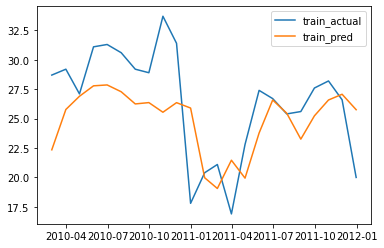

In [23]:
plt.plot(train_result['train_actual'], label='train_actual')
plt.plot(train_result['train_pred'], label='train_pred')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
print(f'Test R-Squared: {round(r2_score(inv_y, inv_yhat) * 100, 2)}%')
print(f'Test RMSE: {round(rmse, 2)}')
print(f'Test MAPE: {round(mape(inv_y, inv_yhat), 2)}%')

3/3 [==============================] - 0s 7ms/step
Test R-Squared: 1.5%
Test RMSE: 10.65
Test MAPE: 123.83%


In [25]:
result = pd.DataFrame({'actual': inv_y, 'pred': inv_yhat}, index=reframed.loc[test_start:test_end].index)

In [26]:
rmse_each_month = []
for index, value in result.iterrows():
    rmse_each_month.append(round(mean_squared_error([value['actual']], [value['pred']], squared=False), 2))
result['rmse'] = rmse_each_month

In [27]:
mape_each_month = []
for index, value in result.iterrows():
    mape_each_month.append(f"{round(mape([value['actual']], [value['pred']]), 2)}%")
result['mape'] = mape_each_month

In [28]:
result

,actual,pred,rmse,mape
tanggal,,,,
2012-01-31,18.7,23.283469,4.58,24.51%
2012-02-29,23.1,20.767429,2.33,10.1%
2012-03-31,20.8,24.370517,3.57,17.17%
2012-04-30,29.0,23.612954,5.39,18.58%
2012-05-31,29.9,26.702610,3.20,10.69%
...,...,...,...,...
2019-08-31,25.3,26.715211,1.42,5.59%
2019-09-30,22.5,25.567514,3.07,13.63%
2019-10-31,23.6,26.591744,2.99,12.68%


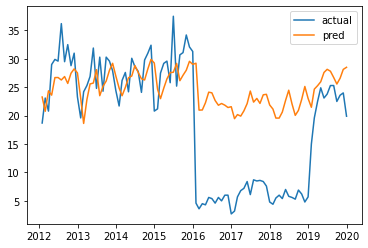

In [29]:
plt.plot(result['actual'], label='actual')
plt.plot(result['pred'], label='pred')
plt.legend()
plt.show()